In [1]:
import math
import torch
import gpytorch
import copy
import spectralgp
from spectralgp.priors import GaussianProcessPrior
from gpytorch.kernels.kernel import Kernel
#from botorch import fit_gpytorch_model
from torch.nn import ModuleList
import matplotlib.pyplot as plt
import numpy as np
from gpytorch.priors import NormalPrior
from scipy.io import loadmat
torch.set_default_dtype(torch.float64)
from torch.nn.functional import softplus

# Testing the Latent kernel with Latent Mean

In [2]:
class LogRBFMean(gpytorch.means.Mean):
    """
    Log of an RBF Kernel's spectral density
    """
    def __init__(self, hypers = None):
        super(LogRBFMean, self).__init__()
        if hypers is not None:
            self.register_parameter(name="constant", parameter=torch.nn.Parameter(hypers[-5] + softplus(hypers[-3]).log()))
            self.register_parameter(name="lengthscale", parameter=torch.nn.Parameter(hypers[-4]))
        else:
            self.register_parameter(name="constant", parameter=torch.nn.Parameter(0. * torch.ones(1)))
            self.register_parameter(name="lengthscale", parameter=torch.nn.Parameter(-0.3*torch.ones(1)))

        # register prior
        self.register_prior(name='constant_prior', prior=NormalPrior(torch.zeros(1), 100.*torch.ones(1), transform=None),
            param_or_closure='constant')
        self.register_prior(name='lengthscale_prior', prior=NormalPrior(torch.zeros(1), 100.*torch.ones(1), transform=torch.nn.functional.softplus),
            param_or_closure='lengthscale')

    def set_pars(self, hypers):
        self.constant.data = hypers[-2]
        self.lengthscale.data = hypers[-1]

    def forward(self, input):
        # logrbf up to constants is: c - t^2 / 2 *l 
        #out = torch.exp(self.constant - (input[:,0]-input[:,1]).pow(2) / (2 * (softplus(self.lengthscale.view(-1)) + 1e-7) ))
        out = self.constant - (input[:,0]-input[:,1]).pow(2) / (2 * (softplus(self.lengthscale.view(-1)) + 1e-7) )
        return out


In [3]:
# We will use the simplest form of GP model, exact inference
# TODO: set transforms
class LatentGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, mean=gpytorch.means.ZeroMean, grid = False):
        super(LatentGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = mean()

        self.covar_module = gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.MaternKernel(nu=1.5,
                    lengthscale_prior = gpytorch.priors.NormalPrior(torch.zeros(1), torch.ones(1),
                                            transform=torch.exp)
                    ),
                    outputscale_prior = gpytorch.priors.NormalPrior(torch.zeros(1), torch.ones(1),
                                            transform=torch.exp)
                )

        self.grid = grid
        if self.grid:
            self.grid_module = gpytorch.kernels.GridKernel(self.covar_module, grid = train_x.unsqueeze(1))

    def forward(self, x):
        mean_x = self.mean_module(x)
        if self.grid:
            covar_x = self.grid_module(x)
        else:
            covar_x = self.covar_module(x)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [4]:
def plot3D(model, likelihood,xtrain,ytrain,std,meanY,title):
    zaxisU = np.zeros((40,40))
    zaxisL = np.zeros((40,40))
    xaxis= np.arange(0,1.2, 0.03)
    yaxis = np.arange(0,1.2, 0.03)
    xaxis, yaxis = np.meshgrid(xaxis, yaxis)
    ytrain = ytrain*std+meanY
    for i in range(40):    
        xtest = np.zeros((40,2))
        ycon = yaxis[i,0]
        xtest[:,1] = ycon*np.ones(40); ##Calculate the 3D Mesh by y row y constant
        xtest[:,0] = xaxis[i,:] ## X variable
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            xtest = torch.tensor(xtest).double()
            f_preds= test(model, likelihood, xtest)
            lower, upper = f_preds.confidence_region()
            zaxisU[i,:] = upper.cpu()*std+meanY ##Upper bound of our guess
            zaxisL[i,:] = lower.cpu()*std+meanY
            #zaxisL[i,:] = f_preds.mean.cpu()*std+meanY ##Lowe bound of our guess
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    print(ytrain.shape)
    #ax.scatter(xtrain[:,0].cpu(), xtrain[:,1].cpu(), torch.exp(ytrain).cpu(), c='#2ca02c')
    surf = ax.plot_surface(xaxis, yaxis, np.exp(zaxisU), #Plot upper
                            linewidth=0, antialiased=False)
    surf = ax.plot_surface(xaxis, yaxis, np.exp(zaxisL), #Plot lower
                            linewidth=0, antialiased=False)
    ax.view_init(30, 60)
    ax.set_title(title)



In [5]:
def train(model, likelihood, train_x, train_y):# Find optimal model hyperparameters
    model.train()
    likelihood.train()
    training_iter =100;
    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

def test(model, likelihood, test_x):
    model.eval() ##Test takes model returns output
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        f_preds = likelihood(model(test_x)) 
    return f_preds


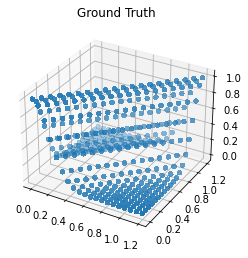

In [6]:
num_locs = 20
num_locs1 = 20
num_locs2 = 20
max_tau = 100.0
##Initialize the log periodgram to a vague idea of a RBF Spectrogram
log_periodogram = torch.zeros(num_locs1*num_locs2).double()
#Initial inputs for a GP are two dimensional values.
omega = torch.zeros((num_locs1*num_locs2,2)).double()
rownum = 0;
omega1 = math.pi * 2. * torch.arange(num_locs).double().div(max_tau)
omega2 = math.pi * 2. * torch.arange(num_locs).double().div(max_tau)

for i in range(num_locs1):
    for j in range(num_locs2):
        omega[rownum,0] = omega1[i]
        omega[rownum,1] = omega2[j]
        ## this is an estimate to say you are closely correlated to frequnecy about +/-10% 
        ##Away from you in terms of range.
        log_periodogram[rownum] = -(max_tau/6.28)*((omega[rownum,0] - omega[rownum,1])**2)
        rownum = rownum+1;
        
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.scatter(omega[:,0].cpu(), omega[:,1].cpu(), torch.exp(log_periodogram).cpu(),
                       linewidth=0, antialiased=False)
ax.set_title("Ground Truth")
xtrain = omega;
ytrain = log_periodogram

torch.Size([400])


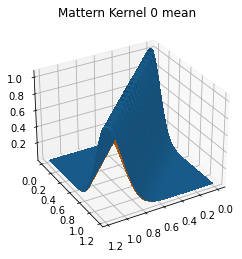

In [7]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise_covar.noise =0.01 # CovarNoise rescaled by std
model  =  LatentGPModel(xtrain , ytrain , likelihood)
train(model, likelihood, xtrain, ytrain)
plot3D(model, likelihood,xtrain,ytrain,1,0.0,"Mattern Kernel 0 mean")

torch.Size([400])


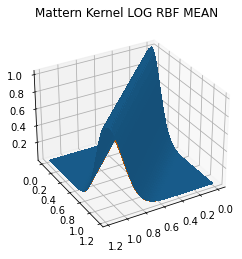

In [8]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise_covar.noise =0.01 # CovarNoise rescaled by std
model  =  LatentGPModel(xtrain , ytrain , likelihood, mean = LogRBFMean)
train(model, likelihood, xtrain, ytrain)
plot3D(model, likelihood,xtrain,ytrain,1,0.0,"Mattern Kernel LOG RBF MEAN")

# NON STATIONARY KERNEL

In [96]:
class NonStatGPKernel(Kernel):
    def __init__(self, omega = None, num_locs = 50, normalize = False, transform = torch.exp, symmetrize = False,
                    **kwargs):
        r"""
        integration: {U, MC} U is trapezoidal rule, MC is Mone Carlo w/ w \sim U(-pi, pi)
        num_locs: number of omegas
        normalize: enforce that integral = 1
        transform: S(\omega) := transform(latent_params(\omega)), default: torch.exp
        symmetrize: use g^*(\omega) := 1/2 * (g(-\omega) + g(\omega))
        """
        super(NonStatGPKernel, self).__init__(**kwargs)

        self.normalize = normalize
        self.transform = transform
        self.symmetrize = symmetrize

        self.num_locs = num_locs


        self.register_parameter('latent_params', torch.nn.Parameter(torch.zeros(self.num_locs**2)))

    def initialize_from_data(self, train_x, train_y, spacing='random',
            latent_lh = None, latent_mod = None, period_factor = 150.,
            latent_mean=None, omega1=None, omega2=None, **kwargs):
        """
        Spectral methods require a bit of hand-initialization - this is analogous to the SM
        intialize_from_data method.
        train_x: train locations
        train_y: train responses
        num_locs: number of omegas to use
        spacing: type of periodogram to use
        latent_lh: latent model's likliehood function, if non-standard
        latent_mod: latent model
        period_factor: constant to multiply on period
        """
        print("We are using this many omegas", self.num_locs)
        if omega1 is None or omega2 is None:
            x1 = train_x.unsqueeze(-1)
            x2 = train_x.unsqueeze(-1)
            tau = self.covar_dist(x1, x2, square_dist=False, diag=False,
                                  last_dim_is_batch=False)

            max_tau = torch.max(tau)
            # print(max_tau)
            max_tau = period_factor * max_tau
            omega1 = math.pi * 2. * torch.arange(self.num_locs).double().div(max_tau)
            omega2 = math.pi * 2. * torch.arange(self.num_locs).double().div(max_tau)
            # print(omega)
        self.register_parameter('omega1', torch.nn.Parameter(omega1))
        self.omega1.requires_grad = False
        self.register_parameter('omega2', torch.nn.Parameter(omega2))
        self.omega2.requires_grad = False
        self.num_locs1 = (len(self.omega1))
        self.num_locs2 = (len(self.omega2))
        ##Initialize the log periodgram to a vague idea of a RBF Spectrogram
        log_periodogram = torch.zeros(self.num_locs1*self.num_locs2).double()
        #Initial inputs for a GP are two dimensional values.
        omega = torch.zeros((self.num_locs1*self.num_locs2,2)).double()
        self.register_parameter('omega', torch.nn.Parameter(omega))
        self.omega.requires_grad = False
        rownum = 0;
        for i in range(self.num_locs1):
            for j in range(self.num_locs2):
                omega[rownum,0] = omega1[i]
                omega[rownum,1] = omega2[j]
                ## this is an estimate to say you are closely correlated to frequnecy about +/-10% 
                ##Away from you in terms of range.
                log_periodogram[rownum] = -(max_tau/16)*((omega[rownum,0] - omega[rownum,1])**2)
                rownum = rownum+1;
        # if latent model is passed in, use that
        if latent_lh is None:
            self.latent_lh = gpytorch.likelihoods.GaussianLikelihood(noise_prior=gpytorch.priors.SmoothedBoxPrior(1e-8, 1e-3))
        else:
            print("Using specified latent likelihood")
            self.latent_lh = latent_lh
        if latent_mod is None:
            if latent_mean is None:
                print("Using LogRBF latent mean")
                latent_mean = LogRBFMean
            ## Gaussian Process Model
            self.latent_mod = LatentGPModel(omega, log_periodogram, self.latent_lh, mean=latent_mean)
            # if isinstance(self.latent_mod.mean_module, spectralgp.means.SM_Mean):
                # self.latent_mod.mean_module.init_from_data(train_x, train_y)
        else:
            print("Using specified latent model")
            self.latent_mod = latent_mod
            #update the training data to include this set of omega and log_periodogram
            self.latent_mod.set_train_data(self.omega, log_periodogram, strict=False)

        self.latent_mod.train()
        self.latent_lh.train()
        # set the latent g to be the demeaned periodogram
        # and make it not require a gradient (we're using ESS for it)
        self.latent_params.data = log_periodogram#self.latent_mod(*self.latent_mod.train_inputs).sample()
        self.latent_params.requires_grad = False

        # clear cache and reset training data
        self.latent_mod.set_train_data(inputs = self.omega, targets=self.latent_params.data, strict=False)

        # register prior for latent_params as latent mod
        latent_prior = GaussianProcessPrior(self.latent_mod, self.latent_lh)
        self.register_prior('latent_prior', latent_prior, lambda: self.latent_params)

        return self.latent_lh, self.latent_mod
    ##Computes a double integral based on 2 values along a diagonal 
    def compute_diag(self, X1,X2, density, normalize=True, fast=False):
        diff1 = self.omega1[1] - self.omega1[0]
        diff2 = self.omega2[1] - self.omega2[0]
        integral = torch.zeros_like(X1)
        for i in range(self.num_locs1):
            row_integral = torch.zeros_like(X1)
            for j in range(self.num_locs2):
                S = self.omega1[i] * X1 - self.omega2[j] * X2
                exp = torch.cos(2.0 * math.pi * S)
                exp = exp + torch.cos(2.0 * math.pi * (self.omega2[j] * X1 - self.omega1[i] * X2))
                exp = exp + torch.cos(2.0 * math.pi * self.omega1[i] * (X1 -  X2))
                exp = exp + torch.cos(2.0 * math.pi * self.omega2[j] * (X1 -  X2))
                ##Symmetric Density
                curr_integrand = density[i*self.num_locs2+j]*exp
                if (i==0) or (i==(self.num_locs2-1)):
                    curr_integrand = curr_integrand/2
                row_integral = row_integral + curr_integrand
            if (i==0) or (i==(self.num_locs1-1)):
                row_integral = row_integral/2;
            integral = row_integral+ integral
        ##WE BELIEVE IN EQUALLY SPACE INTEGRALS NOTHING ELSE
        integral = diff1*integral*diff2*0.25
        return integral

    def compute_kernel_values(self, X1,X2, density, normalize=True, fast=False):
        Kernel = torch.zeros((X1.numel(),X2.numel()))
        tempX1 = X1
        tempX2 = X2
        for i in range(X2.numel()-1):
            input_x2 = tempX2[:X1.numel()]
            integral = self.compute_diag(tempX1,input_x2, density=density, normalize=self.normalize, fast=False)
            numberInter = min(X1.numel(), X2.numel()-i);
            for j in range(numberInter):
                Kernel[j,j+i] = integral[j];
                if (j+i) < X1.numel():
                    Kernel[j+i,j] = integral[j];
            tempX2=torch.roll(tempX2,-1,0)
        ## Add an identity for numerical stability
        return Kernel + 0.1*torch.eye(X2.numel())[:X1.numel(), :X2.numel()];

    def forward(self, x1, x2=None, diag=False, last_dim_is_batch=False,
                **kwargs):
        # print("in fkl x1 = ", x1.shape)
        # print("in fkl x2 = ", x2.shape)
        # print(last_dim_is_batch)
        # print(len(self.omega))
        x1_ = x1
        x2_ = x1 if x2 is None else x2
        # print("in FKL x1_", x1_.shape)
        # print("in FKL x2_", x2_.shape)
        # print("in FKL tau = ", tau.shape)
        # transform to enforce positivity
        density = self.transform(self.latent_params)
        #print(self.latent_params, "latent params")
        #print(torch.exp(self.latent_params), "exp(latent params)")
        #print(density, "density")


        output = self.compute_kernel_values(x1_,x2_, density=density,
                                            normalize=self.normalize, fast=False)
        #print("in FKL output = ", output.shape)
       # print(output)
        if diag:
            output = output.diag()
        return output

    def get_latent_mod(self, idx=None):
        return self.latent_mod

    def get_latent_lh(self, idx=None):
        return self.latent_lh

    def get_omega(self, idx=None):
        return self.omega

    def get_latent_params(self, idx=None):
        return self.latent_params

    def set_latent_params(self, g, idx=None):
        #print("here")
        self.latent_params.data = g


In [97]:
def read_data(dataset, only_scale = False, **kwargs):
    D = loadmat("./dataset/{}.mat".format(dataset))
    ##LOad Data from dataset
    train_x = D['xtrain']
    train_y = D['ytrain']
    test_x = D["xtest"]
    test_y = D["ytest"]
    
    ##Calculate Mean and standard deviation 
    meanY = np.array(train_y).sum()/len(train_y);
    std = np.array(train_y).std();
    meanX = np.array(train_x).sum()/len(train_x);
    std_x = np.max(train_x);
    train_x = (train_x)/std_x #Divide by standard deviation
    train_y = (train_y-meanY)/std #Divide by standard deviation
    train_x = torch.tensor(train_x).double().flatten()#.unsqueeze(1)
    train_y = torch.tensor(train_y).double().flatten()
    test_y = (test_y-meanY)/std ##For plotting function to work nicely
    test_y = torch.tensor(test_y).double().flatten()
    test_x = test_x/std_x
    test_x = torch.tensor(test_x).double().flatten()#.unsqueeze(1)

    y_std_train = torch.std(train_y)
    y_std_full = torch.std(torch.cat([train_y, test_y]))

    return train_x, train_y, test_x, test_y, y_std_full, y_std_train, _
dataset = 'airline'
print("Dataset: {}".format(dataset))
train_x, train_y, test_x, test_y, y_std, y_std_train, __ = read_data(dataset)
in_dims = 1 if train_x.dim() == 1 else train_x.size(1)


full_x = torch.cat([train_x,test_x],dim=0).double();
full_y = torch.cat([train_y,test_y],dim=0).double();

Dataset: airline


In [98]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)
    train_x, train_y, test_x, test_y, y_std = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda(), y_std.cuda()

In [99]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, **kwargs):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = NonStatGPKernel(**kwargs)
        self.covar_module.initialize_from_data(train_x, train_y, **kwargs)
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Training

In [100]:
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_prior=gpytorch.priors.SmoothedBoxPrior(1e-8, 1e-4))
model = ExactGPModel(train_x, train_y, likelihood, num_locs=50)

We are using this many omegas 50
Using LogRBF latent mean


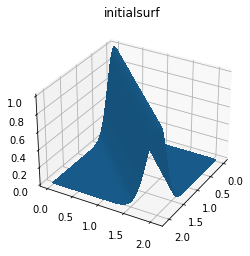

In [101]:
##Plots the object as a surface instead of a scatter
def plot3D_surface(X,Y,Z,title):
    xaxis, yaxis = np.meshgrid(X, Y)
    Length = X.shape[0]
    Width = Y.shape[0]
    zaxis = np.zeros((Length,Width))
    rownum = 0;
    for i in range(Length):
        for j in range(Width):
            zaxis[i,j] = (Z[rownum] + Z[j*Width+i])*0.5
            rownum+=1
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(xaxis, yaxis, zaxis, #Plot upper
                            linewidth=0, antialiased=False)
    ax.view_init(30, 30)
    ax.set_title(title)
    
latent_params = torch.exp(model.covar_module.get_latent_params()).cpu()
plot3D_surface(model.covar_module.omega1.cpu(),model.covar_module.omega2.cpu(),
               latent_params,'initialsurf')

In [102]:
n_iters = 5
ess_iters = 5
optim_iters = 5
##Code to endless reinitalize the start condition till a good initial has been met
while True:
    try:
        likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_prior=gpytorch.priors.SmoothedBoxPrior(1e-8, 1e-4))
        model = ExactGPModel(train_x, train_y, likelihood, nomg=50)
        alt_sampler = spectralgp.samplers.AlternatingSampler(
            [model], [likelihood], 
            spectralgp.sampling_factories.ss_factory, [spectralgp.sampling_factories.ess_factory],
            totalSamples=n_iters, numInnerSamples=ess_iters, numOuterSamples=optim_iters
            )
        alt_sampler.run()
        break
    except KeyboardInterrupt:    
        break
    except:
        pass

We are using this many omegas 50
Using LogRBF latent mean
Loss is:  tensor(-89.3246, grad_fn=<DivBackward0>)
Loss is:  tensor(-88.4114, grad_fn=<DivBackward0>)
Loss is:  tensor(-87.4556, grad_fn=<DivBackward0>)
Loss is:  tensor(-86.4953, grad_fn=<DivBackward0>)
Loss is:  tensor(-85.5648, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Seconds for Iteration 0 : 3855.1104006767273
Loss is:  tensor(-68.5825, grad_fn=<DivBackward0>)
Loss is:  tensor(-67.8375, grad_fn=<DivBackward0>)
Loss is:  tensor(-67.0339, grad_fn=<DivBackward0>)
Loss is:  tensor(-66.2743, grad_fn=<DivBackward0>)
Loss is:  tensor(-65.4845, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 1
Seconds for Iteration 1 : 4222.854377746582
Loss is:  tensor(-63.7052, grad_fn=<DivBackward0>)
Loss is:  tensor(-63.0233, grad_fn=<DivBackward0>)
Loss is:  tensor(-62.3065, grad_fn=<DivBackward0>)
Loss is:  tensor(-61.5200, grad_fn=<DivBackward0>)
Loss is:  tensor(-60.8053, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 2
Seconds for Iteration 

torch.Size([2500])
torch.Size([2500, 2])


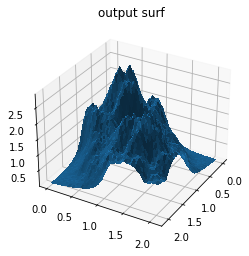

In [103]:
latent_params = torch.exp(model.covar_module.get_latent_params())
omega = model.covar_module.get_omega();
print(latent_params.shape)
print(omega.shape)
latent_params = torch.exp(model.covar_module.get_latent_params()).cpu()
plot3D_surface(model.covar_module.omega1.cpu(),model.covar_module.omega2.cpu(),
               latent_params,'output surf')

In [104]:
model.eval()
n_samples = 10
spectrum_samples = alt_sampler.gsampled[0][0,:, -10:].detach()

predictions = torch.zeros(len(full_x), 10).double() # predictions for each sample
upper_bds = torch.zeros(len(full_x), 10).double() # upper conf. bd for each sample
lower_bds = torch.zeros(len(full_x), 10).double() # lower conf. bd for each sample

with torch.no_grad():
    for ii in range(n_samples):
        model.covar_module.set_latent_params(spectrum_samples[:, ii])
        model.set_train_data(train_x, train_y) # to clear out the cache
        pred_dist = model(full_x.cuda()) 
        lower_bds[:, ii], upper_bds[:, ii] = pred_dist.confidence_region()
        predictions[:, ii] = pred_dist.mean

# Testing

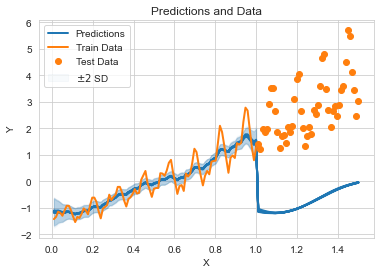

In [105]:
import seaborn as sns
import matplotlib.cm as cm
full_x = full_x.cpu()
full_y = full_y.cpu()
sns.set_style("whitegrid")
colors = cm.get_cmap("tab10")
## plot the predictions ##
plt.plot(full_x.cpu().numpy(), predictions[:, 0].cpu().detach().numpy(), label="Predictions",
         color=colors(0), linewidth=2)
plt.plot(full_x.cpu().numpy(), predictions.cpu().detach().numpy(), linewidth=2, 
         color=colors(0))

## Shade region +/- 2 SD around the mean ##
plt.fill_between(full_x.cpu().numpy(), lower_bds[:, 0].cpu().detach().numpy(), 
                 upper_bds[:, 0].cpu().detach().numpy(),
                 color=colors(0), 
                 alpha=0.03, label = r"$\pm 2$ SD")
for ii in range(n_samples):
    plt.fill_between(full_x.cpu().numpy(), lower_bds[:, ii].cpu().detach().numpy(), 
                     upper_bds[:, ii].cpu().detach().numpy(), 
                     color=colors(0), 
                     alpha=0.03)
    
## plot data ##
plt.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), color=colors(1),
        linewidth=2, label="Train Data")
plt.plot(test_x.cpu().numpy(), test_y.cpu().numpy(), color=colors(1),
        linestyle="None", marker=".", markersize=12,
        label="Test Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Predictions and Data")
plt.legend()
plt.show()


# Testing Double Integral Function

In [22]:
def compute_diag( X1,X2, omega1,omega2, density, normalize=False, fast=False):
    diff1 = omega1[1] - omega1[0] 
    diff2 = omega2[1] - omega2[0]
    num_locs1 = omega1.shape[0]
    num_locs2 = omega2.shape[0]
    integral = torch.zeros_like(X1)
    for i in range(num_locs1):
        row_integral = torch.zeros_like(X1)
        for j in range(num_locs2):
            S = omega1[i] * X1 - omega2[j] * X2
            dense = density[i*num_locs2+j] + density[j*num_locs2+i]
            curr_integrand =dense  * torch.cos(2.0 * math.pi * S)
            if (i==0) or (i==(num_locs2-1)):
                curr_integrand = curr_integrand/2
            row_integral = row_integral + curr_integrand
        if (i==0) or (i==(num_locs1-1)):
            row_integral = row_integral/2;
        integral = row_integral + integral
    ##WE BELIEVE IN EQUALLY SPACE INTEGRALS NOTHING ELSE
    integral = diff1*integral *diff2*0.5
    return integral

##Change Num_locs1 to Num_locs2 

In [27]:
X1 = 1;
X2 = 1;
omega1 = np.arange(0,100+0.0001, 1)
omega2 = np.arange(0,100+0.0001, 1)
density = np.ones(omega1.shape[0]*omega2.shape[0])
X1 = torch.tensor(X1)
X2 = torch.tensor(X2)
omega1 = torch.tensor(omega1)
omega2 = torch.tensor(omega2)
density = torch.tensor(density)
rownum = 0
for i in range(omega1.shape[0]):
    for j in range(omega2.shape[0]):
        density[rownum] = torch.exp(-1*((omega1[i] - omega2[j])**2))
        rownum = rownum+1;

print(compute_diag( X1,X2, omega1,omega2, density, normalize=False, fast=False))
##You can verify the results at this website
#https://www.wolframalpha.com/input/?i=double+integral+calculator
#Function is as follows swap X1 and X2 with real values to see if the results are good
#With 50 we have about 0.6% error from the true integral. 
#I think we need atleast 50 number of locations. 
#Any lower and the integral is highly inaccurate
#(e^(-1*(a-b)^2))(cos(X1*2*pi*a-X2*2*pi*b))

tensor(0.0608)


In [26]:
print(omega1.shape)

torch.Size([101])
